In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [3]:
!pip -q install --upgrade --no-cache-dir gdown

In [4]:
!gdown 1UO8sV72QpdvCQQ9belgwUEXauI16QDHl

Downloading...
From: https://drive.google.com/uc?id=1UO8sV72QpdvCQQ9belgwUEXauI16QDHl
To: /kaggle/working/dataset_img_v5.zip
100%|███████████████████████████████████████| 2.07G/2.07G [00:16<00:00, 127MB/s]


In [5]:
!gdown 1McXv7ak1Z6zlxOA8y7EDLfsSlEkdcb4f

Downloading...
From: https://drive.google.com/uc?id=1McXv7ak1Z6zlxOA8y7EDLfsSlEkdcb4f
To: /kaggle/working/best.pt
100%|████████████████████████████████████████| 114M/114M [00:01<00:00, 69.3MB/s]


In [6]:
!unzip -qq dataset_img_v5.zip
!mv dataset_img_v5/ dataset/

In [8]:
import torch
import torch.nn as nn
import torchvision as tv
import torch.optim as optim
from skimage.io import imread_collection
from torch.utils.data import DataLoader, random_split, Dataset
import pandas as pd
import ast
import json
import os
import numpy as np
import math 
import itertools

from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
from matplotlib import pyplot as plt

In [9]:
def flatten(nested_list):
    return [item for sublist in nested_list for item in sublist]

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [20]:
root = '/kaggle/working/dataset'
sequence_dir_list = sorted(os.listdir(root + '/sequences/'))

df = pd.DataFrame()
ground_truth=[]
sequence_num=[]
bird_eye_view_full_path = []
height_img360_full_path = []
img360_full_path = []
intensity_img360_full_path = []
range_img360_full_path = []

poses_file_list = sorted(os.listdir(root + '/poses/'))
for fname in poses_file_list:
  poses = np.loadtxt(root + '/poses/' + fname)
  poses = poses.reshape(-1, 3, 4)
  gt=[]
  prev_pose= [0]*6
  for pose in poses:
    decomposed = cv2.decomposeProjectionMatrix(pose)
    transVect, eulerAngles = decomposed[2], decomposed[-1]
    transVect = transVect/transVect[3]
    curr_pose = np.concatenate((transVect[:-1],eulerAngles)).ravel()
    # print(np.round(prev_pose[3:]),np.round(curr_pose[3:]))
    for i in range(3,6):

      if curr_pose[i] < prev_pose[i] - 180: curr_pose[i] = 360 + curr_pose[i] 
      if curr_pose[i] > prev_pose[i] + 180: curr_pose[i] = -360 + curr_pose[i]
    prev_pose = curr_pose
    gt.append(prev_pose)
  ground_truth.append(gt)
ground_truth= list(itertools.chain(*ground_truth))





for seq_dir in sequence_dir_list:
  seq_path = root + '/sequences/' + seq_dir 
  bird_eye_view_file_list = sorted(os.listdir(seq_path+ '/bird_eye_view/'))
  bird_eye_view_file_list = [ seq_path+ '/bird_eye_view/' + s for s in bird_eye_view_file_list]
  height_img360_file_list = sorted(os.listdir(seq_path+'/height_img360/'))
  height_img360_file_list = [ seq_path+'/height_img360/' + s for s in height_img360_file_list]
  img360_file_list = sorted(os.listdir(seq_path+ '/img360/'))
  img360_file_list = [ seq_path+ '/img360/' + s for s in img360_file_list]
  intensity_img360_file_list = sorted(os.listdir(seq_path+'/intensity_img360/'))
  intensity_img360_file_list = [ seq_path+'/intensity_img360/' + s for s in intensity_img360_file_list]
  range_img360_file_list = sorted(os.listdir(seq_path+'/range_img360/'))
  range_img360_file_list = [ seq_path+'/range_img360/' + s for s in range_img360_file_list]
  seq_num = [seq_dir]*len(img360_file_list)
  sequence_num.append(seq_num)
  bird_eye_view_full_path.append(bird_eye_view_file_list)
  height_img360_full_path.append(height_img360_file_list)
  img360_full_path.append(img360_file_list)
  intensity_img360_full_path.append(intensity_img360_file_list)
  range_img360_full_path.append(range_img360_file_list)

sequence_num= list(itertools.chain(*sequence_num))
bird_eye_view_full_path =  list(itertools.chain(*bird_eye_view_full_path))
height_img360_full_path =  list(itertools.chain(*height_img360_full_path))
img360_full_path =  list(itertools.chain(*img360_full_path))
intensity_img360_full_path =  list(itertools.chain(*intensity_img360_full_path))
range_img360_full_path =  list(itertools.chain(*range_img360_full_path))


df['seq_num'] = sequence_num
df['ground_truth'] = ground_truth
df['bird_eye_view'] = bird_eye_view_full_path
df['height'] = height_img360_full_path
df['img360'] = img360_full_path
df['intensity'] = intensity_img360_full_path
df['range'] = range_img360_full_path

ground_truth_df = pd.DataFrame(df['ground_truth'])
ground_truth_df = pd.DataFrame(df['ground_truth'].to_list(), columns=['x','y','z','alpha','beta','gamma'])

gt_df = ground_truth_df.copy()
gt_df.drop(['y', 'alpha', 'gamma'], axis=1, inplace=True)
df['beta'] = gt_df['beta']
df['x'] = gt_df['x']
df['z'] = gt_df['z']

df.head()

,seq_num,ground_truth,bird_eye_view,height,img360,intensity,range,beta,x,z
0,00,"[-5.551115000732093e-17, -3.330669001057406e-1...",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...,-0.000000,-5.551115e-17,4.440892e-16
1,00,"[0.045113447450264826, 0.027431373395956728, -...",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...,-0.118392,4.511345e-02,-8.588215e-01
2,00,"[0.08659615738057902, 0.05288997897173165, -1....",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...,-0.236570,8.659616e-02,-1.716774e+00
3,00,"[0.12455777890801757, 0.07643581057741401, -2....",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...,-0.354841,1.245578e-01,-2.576066e+00
4,00,"[0.15890632423944687, 0.09800444791778, -3.434...",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...,-0.472913,1.589063e-01,-3.434568e+00


In [12]:
class KittiDataset(Dataset):
    def __init__(
        self, df: pd.core.frame.DataFrame, seq_nums: list,
         transforms: list = None, bin_size: int = 21
    ):
        super().__init__()

        if transforms is None:
            transforms =  tv.transforms.ToTensor()
        self.transforms = transforms

        intensity_list = []
        range_list = []
        height_list = []

        for seq_num in seq_nums:
            # intensity_list.append(df[df['seq_num'].isin([seq_num])]['intensity'].tolist())
            range_list.append(df[df['seq_num'].isin([seq_num])]['range'].tolist())
            # height_list.append(df[df['seq_num'].isin([seq_num])]['height'].tolist())

        # self.intensity_list = [(intensity[i], intensity[i + 1]) for intensity in intensity_list for i in range(len(intensity) - 1)]


        self.range_list = [(rng[i], rng[i+1]) for rng in range_list for i in range(len(rng) - 1)]
        # self.height_list = [(height[i], height[i+1]) for height in height_list for i in range(len(height) - 1)]
        
        transes = []
        rot = []

        for seq_num in seq_nums:
            dx = np.diff(df[df['seq_num'].isin([seq_num])].iloc[:]['x'])
            dz = np.diff(df[df['seq_num'].isin([seq_num])].iloc[:]['z'])
            transes.append(np.sqrt(dx ** 2 + dz ** 2))

            rot.append(np.diff(df[df['seq_num'].isin([seq_num])].iloc[:]['beta']))

        self.trans = np.hstack(transes)
        self.rot = np.hstack(rot).flatten()
        
        self.trans_bins = np.linspace(self.trans.min(), self.trans.max(), bin_size)
        self.trans_labels = torch.tensor(np.digitize(self.trans, self.trans_bins)).long() -1

        self.rot_bins = np.linspace(self.rot.min(), self.rot.max(), bin_size)
        self.rot_labels = torch.tensor(np.digitize(self.rot, self.rot_bins)).long() -1

    def __getitem__(self, index):

        # intensity1, intensity2 = self.intensity_list[index]
        range1, range2 = self.range_list[index]
        # height1, height2 = self.height_list[index]

        # ch1 = self.transforms(Image.open(intensity1))
        ch2 = self.transforms(Image.open(range1))
        # ch3 = self.transforms(Image.open(height1))
        
        # ch4 = self.transforms(Image.open(intensity2))
        ch5 = self.transforms(Image.open(range2))
        # ch6 = self.transforms(Image.open(height2))

        images = torch.stack([ ch2, ch5], axis=0)
        # images = torch.cat([ ch2, ch5], dim=0)
        # images = torch.cat([ch1, ch2, ch3, ch4, ch5, ch6], dim=0)
        trans_label = self.trans_labels[index]
        rot_label = self.rot_labels[index]

        return  images, trans_label, rot_label

    def __len__(self):
        return len(self.rot_labels)

In [13]:
class OdometryEstimator(nn.Module):
    def __init__(
        self, img_size: tuple = None,channel_size:int=None, batchNorm: bool = True,
        dropout: list = None, out_features: int = 21, seq_len: int = 2
    ):
        super().__init__()

        if img_size is None:
            img_size = (65, 1025)

        if channel_size is None:
            channel_size = 1

        if dropout is None:
            dropout = [0.2] * 9

        self.batchNorm = batchNorm
        self.img_size = img_size
        self.channel_size = channel_size
        self.seq_len = seq_len

        self.conv1 = nn.Sequential(
            nn.Conv2d(self.channel_size, 32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(), # inplace=True),
            nn.AvgPool2d(2),
            nn.Dropout(dropout[0]) #, inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(), # inplace=True),
            nn.AvgPool2d(3),
            nn.Dropout(dropout[0]) # ,inplace=True)
        )

        self.rnn_trans = nn.LSTM(
            input_size=self.encoding_size(), hidden_size=128, num_layers=3,
            dropout=0.1, batch_first=True
        )

        self.rnn_rot = nn.LSTM(
            input_size=self.encoding_size(), hidden_size=128, num_layers=3,
            dropout=0.1, batch_first=True
        )
        
        self.fc_network_rot = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=128, out_features=64
            ),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout[0]), #, inplace=True),
            nn.Linear(in_features=64, out_features=out_features),
            nn.Softmax(dim=-1)
        )

        self.fc_network_trans = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=128, out_features=64
            ),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout[0]), #, inplace=True),
            nn.Linear(in_features=64, out_features=out_features),
            nn.Softmax(dim=-1)
        )

    def encoding_size(self):
        tmp = torch.zeros(1, self.channel_size, *self.img_size)

        self.eval()
        with torch.no_grad():
            out = self.encode_image(tmp)
        self.train()

        return out.numel()

    def encode_image(self, x):
        out = self.conv2(self.conv1(x))

        return out

    def forward(self, x):
        # x shape: (batch_size, sql_len=2, channel=1, height, width)

        batch_size = x.size(0)
#         print(f'-----{x.size()}')
        x = torch.cat(( x[:, :-1], x[:, 1:]), dim=2)
        seq_len = x.size(1)
#         print(f'--cat-{x.size()}')
        
        x = x.view(batch_size * seq_len, x.size(2), x.size(3), x.size(4))
#         print(f'--v  -{x.size()}')
        encoding = self.encode_image(x)
#         print(f'--e-{encoding.size()}')

        encoding = encoding.view(batch_size, seq_len, -1)
        
        rnn_out_trans, _ = self.rnn_trans(encoding)
        # print("Here rnn trans")
        rnn_out_rot, _ = self.rnn_rot(encoding)
        # print("rot trans")
        trans_out = self.fc_network_trans(rnn_out_trans)
        # print("fc trans")
        rot_out = self.fc_network_rot(rnn_out_rot)

        return trans_out, rot_out



In [14]:
stack_len = 2
overlap = 1
channel_size = 1
bins_number = 50
batch_size = 100
img_size = (65, 1025)

In [15]:
img_transform = tv.transforms.Compose([
    # tv.transforms.Resize(img_size),
     tv.transforms.ToTensor()
])

In [16]:
model = OdometryEstimator(img_size, batchNorm=True, dropout=[0.05] * 9, out_features=bins_number, channel_size=2).to(device)

In [17]:
model.load_state_dict(torch.load('best.pt', map_location =device)['model_state'])

<All keys matched successfully>

In [24]:
def test(s_num):
    test_ds = KittiDataset(df, seq_nums=[s_num], transforms=img_transform,bin_size=bins_number)
    test_loader = DataLoader(test_ds, batch_size=batch_size)
    pred_trans = []
    pred_rot = []
    gt_trans = []
    gt_rot = []
    with torch.no_grad():
        for x, y_trans, y_rot in test_loader:
            x, y_trans, y_rot = x.to(device), y_trans.to(device), y_rot.to(device)
            y_hat_trans, y_hat_rot = model(x)
            pred_trans.append(torch.argmax(y_hat_trans,axis=-1).tolist())
            pred_rot.append(torch.argmax(y_hat_rot,axis=-1).tolist())
            gt_trans.append(y_trans)
            gt_rot.append(y_rot)

    pred_rot = flatten(pred_rot)
    pred_trans = flatten(pred_trans)
    gt_trans = list(map(int, flatten(gt_trans)))
    gt_rot = list(map(int, flatten(gt_rot)))
    
    return gt_trans,pred_trans,gt_rot,pred_rot,test_ds


   
    
def plot_test_result(gt_trans,pred_trans,gt_rot,pred_rot,test_ds):

    
    x_vals = [0.]
    y_vals = [0.]
    gt_x_vals = [0.]
    gt_y_vals = [0.]
    counter = 0
    for tr,rot,gt_tr,gt_r in zip(pred_trans,pred_rot,gt_trans,gt_rot):
        d=test_ds.trans_bins[tr]
        theta = test_ds.trans_bins[rot]
        x = math.cos(math.radians(theta))*d
        y = math.sin(math.radians(theta))*d
        x_vals.append(x+x_vals[-1])
        y_vals.append(y+y_vals[-1])

        d=test_ds.trans_bins[gt_tr]
        theta = test_ds.trans_bins[gt_r]
        x = math.cos(math.radians(theta))*d
        y = math.sin(math.radians(theta))*d
        gt_x_vals.append(x+gt_x_vals[-1])
        gt_y_vals.append(y+gt_y_vals[-1])
        if x_vals[-1] == gt_x_vals[-1] and y_vals[-1] == gt_y_vals[-1]:
            counter +=1
    overall_acc = (counter/len(gt_x_vals))*100
    print("Overall Accuracy ="+str(overall_acc)+"%")
    plt.scatter(x_vals,y_vals,label='pred')
    plt.scatter(gt_x_vals,gt_y_vals,label='gt')
    plt.legend()
    plt.show()

    
def show_confution_matrix(classes,y,y_hat,title=''):
    fig, ax = plt.subplots(figsize=(20, 20))
    cm = confusion_matrix(y, y_hat)
    ax.set_title(title)
    cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
    cmd.plot(ax=ax, xticks_rotation=90)

Sequence No. 01:
Overall Accuracy =0.0%


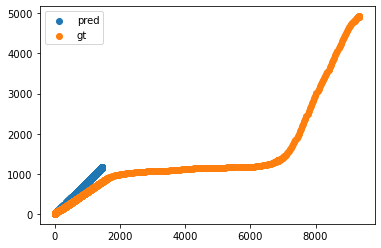

In [29]:
gt_trans,pred_trans,gt_rot,pred_rot,test_ds = test('01')
print("Sequence No. 01:")
plot_test_result(gt_trans,pred_trans,gt_rot,pred_rot,test_ds)

# classes = test_ds.trans_bins
# y = gt_trans
# y_hat = pred_trans

# show_confution_matrix(classes,y,y_hat,title='Translation Confution Matrix for seq. 01')

# y = gt_rot
# y_hat = pred_rot

# show_confution_matrix(classes,y,y_hat,title='Rotation Confution Matrix for seq. 01')

Sequence No. 09:
Overall Accuracy =0.0%


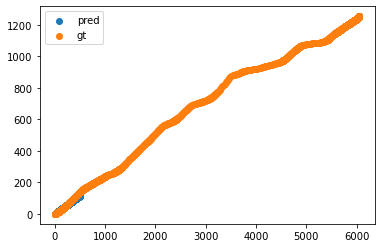

In [31]:
gt_trans,pred_trans,gt_rot,pred_rot,test_ds = test('09')
print("Sequence No. 09:")
plot_test_result(gt_trans,pred_trans,gt_rot,pred_rot,test_ds)

# classes = test_ds.trans_bins
# y = gt_trans
# y_hat = pred_trans

# show_confution_matrix(classes,y,y_hat,title='Translation Confution Matrix for seq. 09')

# y = gt_rot
# y_hat = pred_rot

# show_confution_matrix(classes,y,y_hat,title='Rotation Confution Matrix for seq. 09')